In [44]:
import csv
import os
import glob
import numpy
from PIL import ImageDraw 
from PIL import Image
import matplotlib.pyplot as plt
from PIL import ImageFont

def loadResizeImage(img_path, label=None):
    size = (124, 124)

    # Load the image
    img = Image.open(img_path)
    # Keep the original image size
    old_size = img.size

    # Compute resizing ratio
    ratio = float(size[0]) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    # Actually resize it
    img = img.resize(new_size, Image.ANTIALIAS)

    # Paste into centre of black padded image
    new_img = Image.new("RGB", (size[0], size[1]))
    new_img.paste(img, ((size[0] - new_size[0]) // 2, (size[1] - new_size[1]) // 2))
    if label != None:
        draw = ImageDraw.Draw(new_img)
        font = ImageFont.truetype("/System/Library/Fonts/Supplemental/Arial.ttf", 12)
        draw.text((62, 10),label,(255,255,255),font=font)

    # Convert to numpy
    new_img = numpy.array(new_img, dtype=numpy.uint8)

    return new_img

# Function to compose images in a grid
compose = lambda images, horizontal: numpy.concatenate(
    [img / 255 if horizontal == 1 else img for img in images],
    axis=horizontal,
)

def listDirs(dir):
    images = glob.glob(dir + '/*')
    timestamps = [os.path.getctime(path) for path in images]
    indeces = numpy.argsort(timestamps)
    images = [images[idx] for idx in indeces]
    return images, indeces


In [24]:
# !pip3 install xlsxwriter

     |████████████████████████████████| 149 kB 877 kB/s            


In [45]:
import xlsxwriter
import cv2
from io import BytesIO
# This sorts images based on timestamps. These are used to manually annotate the dataset.
topDir = '/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/identification/images/test/*'
dirs = glob.glob(topDir)
for dir in dirs:
    img, indeces = listDirs(dir)
    # Create an new Excel file and add a worksheet.
    workbook = xlsxwriter.Workbook('./tracklets/{}.xlsx'.format(dir.split('/')[-1]))
    worksheet = workbook.add_worksheet()
    sheetFormat = workbook.add_format({'text_wrap': True})
    # Widen the first column to make the text clearer.
    worksheet.set_column('A:A', 30, sheetFormat)
    worksheet.set_column('B:B', 17)
    for i in range(len(img)):
        # Insert an image.
        worksheet.set_row(i, 92)
        success, img_numpy = cv2.imencode('.jpg', loadResizeImage(img[i], label=str(i)))
        worksheet.write('A{}'.format(i), img[i])
        worksheet.insert_image('B{}'.format(i), img[i], {'image_data': BytesIO(img_numpy.tobytes())})
    workbook.close()

/opt/homebrew/Caskroom/miniforge/base/envs/metricLearning/lib/python3.8/site-packages/xlsxwriter/worksheet.py:1418: UserWarning: Cannot insert image at (-1, 1).
  warn('Cannot insert image at (%d, %d).' % (row, col))


In [ ]:
# topDir = '/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/identification/images/test/*'
# dirs = glob.glob(topDir)
# for dir in dirs:
#     img, indeces = listDirs(dir)
#     fig, ax = plt.subplots(1, figsize=((len(img) * 124)/500, 124/500), dpi=500)
#     img = [loadResizeImage(img[i], label=str(i)) for i in range(len(img))]
#     plt.imshow(compose(img, 1), aspect=1)
#     [ax.spines[spine].set_visible(False) for spine in ["top", "right", "bottom", "left"]]
#     ax.axes.get_xaxis().set_ticks([])
#     ax.axes.get_yaxis().set_ticks([])
#     ax.axis("tight")
#     # print("{} {}".format(dir, len(img)))
#     plt.savefig("./tracklets/{}.png".format(dir.split('/')[-1]), dpi=500)
#     plt.figure().clear()
#     plt.close()
#     plt.cla()
#     plt.clf()
#     # break

In [40]:
import glob
import csv
import numpy
import json
topDir = './tracklets/train/csv/*'
dirs = glob.glob(topDir)
dataSet = {"test": [], "train": [], "valid": []}
for dir in dirs:
    # Parse the train data
    with open(dir) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        data = []
        trackletInd = []
        for row in csv_reader:
            row[0] = row[0].replace('/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/', '')
            category = int(row[0].split('/')[-2])
            data.append([row[0], category, int(row[1])])
            trackletInd.append(int(row[1]))
        dataRow = [{'paths':[]}] * len(numpy.unique(trackletInd))
        for image in data:
            path, category, tracklet = image
            dataRow[tracklet]['label'] = category
            dataRow[tracklet]['paths'].append(path)
        dataSet['train'] += dataRow

topDIR = '/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/identification/images/test/'
with open('utils/openCows2020_test_tracklet.json') as f:
    files = json.load(f)
    for file in files:
        if file['type'] == 'split':
            directories, indeces = listDirs(topDIR + file['cowID'])
            for split in file['splits']:
                sortedIdx = [directories[idx].replace('/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/', '') for idx in split]
                dataSet['test'].append({"label": int(file['cowID']), "paths": sortedIdx})
        else:
            directories, indeces = listDirs(topDIR + file['cowID'])
            directories = [director.replace('/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/', '') for director in directories]
            dataSet['test'].append({"label": int(file['cowID']), "paths": directories})


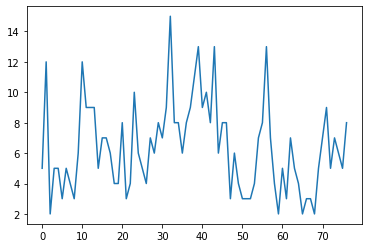

In [42]:
dt = [len(track['paths']) for track in dataSet['test']]
plt.plot(dt)

In [14]:
import json
topDIR = '/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/identification/images/train/'
dataSet = {"test": [], "train": [], "valid": []}
with open('utils/openCows2020_train_tracklet.json') as f:
    files = json.load(f)
    for file in files:
        if file['type'] == 'split':
            directories, indeces = listDirs(topDIR + file['cowID'])
            for split in file['splits']:
                sortedIdx = [directories[idx].replace('/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/', '') for idx in split]
                dataSet['train'].append({"label": int(file['cowID']), "paths": sortedIdx})
        else:
            directories, indeces = listDirs(topDIR + file['cowID'])
            directories = [director.replace('/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/', '') for director in directories]
            dataSet['train'].append({"label": int(file['cowID']), "paths": directories})

topDIR = '/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/identification/images/test/'
with open('utils/openCows2020_test_tracklet.json') as f:
    files = json.load(f)
    for file in files:
        if file['type'] == 'split':
            directories, indeces = listDirs(topDIR + file['cowID'])
            for split in file['splits']:
                sortedIdx = [directories[idx].replace('/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/', '') for idx in split]
                dataSet['test'].append({"label": int(file['cowID']), "paths": sortedIdx})
        else:
            directories, indeces = listDirs(topDIR + file['cowID'])
            directories = [director.replace('/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/', '') for director in directories]
            dataSet['test'].append({"label": int(file['cowID']), "paths": directories})


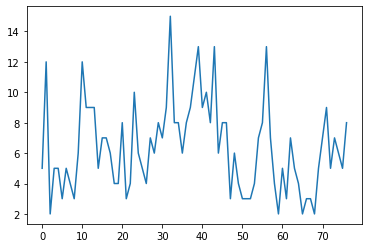

In [23]:
dt = [len(track['paths']) for track in dataSet['test']]
plt.plot(dt)

In [1]:
import csv
import os
import glob
import numpy

def listDirs(dir):
    images = glob.glob(dir + '/*')
    timestamps = [os.path.getctime(path) for path in images]
    indeces = numpy.argsort(timestamps)
    images = [images[idx] for idx in indeces]
    return images

topDir = '/Users/as16542/Downloads/4vnrca7qw1642qlwxjadp87h7/Sub-levels/Identification/Train/RGBDCows2020/Identification/RGB'
dataSet = {"test": [], "train": [], "valid": []}

# Parse the train data
with open('utils/correct.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count > 0 and line_count < 465 and row[6] != 'black':
            label = row[4] if row[4] != '' else row[2]
            if label != '':
                dirs = [dir.replace('/Users/as16542/Downloads/4vnrca7qw1642qlwxjadp87h7/', '') for dir in listDirs(os.path.join(topDir, row[1]))]
                dataSet['train'].append({'label': int(label), 'paths': dirs})
        line_count += 1

# Parse the test data
labels = list(set([item['label'] for item in dataSet["train"]]))
topDir = '/Users/as16542/Downloads/4vnrca7qw1642qlwxjadp87h7/Sub-levels/Identification/Test/'
for label in labels:
    path = os.path.join(topDir, '{:>03}'.format(label))
    dirs = [dir.replace('/Users/as16542/Downloads/4vnrca7qw1642qlwxjadp87h7/', '') for dir in listDirs(path)]
    dataSet["test"].append({'label': int(label), 'paths': dirs})

# Since we omitted black cows we need to hot encode the labels again
labels = list(set([item['label'] for item in dataSet["train"]] + [item['label'] for item in dataSet["test"]]))
hotEncodeMap = {}
for i in range(len(labels)):
    hotEncodeMap[labels[i]] = i

# Now we can use the map the relabel the dataset
for split in dataSet.keys():
    for i in range(len(dataSet[split])):
        dataSet[split][i]['label'] = hotEncodeMap[dataSet[split][i]['label']]

In [95]:
labels = list(set([item['label'] for item in dataSet["train"]] + [item['label'] for item in dataSet["test"]]))
labels

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46]

5 5 5


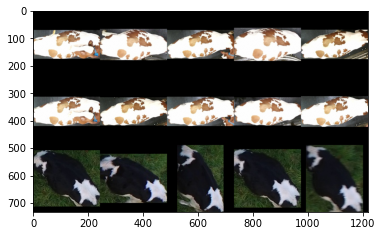

38


In [15]:
from PIL import Image
import matplotlib.pyplot as plt

def loadResizeImage(img_path):
    size = (244, 244)
    # Load the image
    img = Image.open(img_path)

    # Keep the original image size
    old_size = img.size

    # Compute resizing ratio
    ratio = float(size[0]) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    # Actually resize it
    img = img.resize(new_size, Image.ANTIALIAS)

    # Paste into centre of black padded image
    new_img = Image.new("RGB", (size[0], size[1]))
    new_img.paste(img, ((size[0] - new_size[0]) // 2, (size[1] - new_size[1]) // 2))

    # Convert to numpy
    new_img = numpy.array(new_img, dtype=numpy.uint8)

    return new_img

# Function to compose images in a grid
compose = lambda images, horizontal: numpy.concatenate(
    [img / 255 if horizontal == 1 else img for img in images],
    axis=horizontal,
)

topDir = "/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17"
for i in range(38, 39):
    # Sample image from the dataset
    trainSet = None
    testSet = None
    negSet = None
    for j in range(len(dataSet["train"])):
        if dataSet["train"][j]["label"] - 1 == i:
            trainSet = dataSet["train"][j]["paths"]
            break
    for j in range(len(dataSet["test"])):
        if dataSet["test"][j]["label"] - 1 == i:
            testSet = dataSet["test"][j]["paths"]
            break
    for j in range(len(dataSet["test"])):
        if dataSet["test"][j]["label"] - 1 == i+1:
            negSet = dataSet["test"][j]["paths"]
            break
    # Take first 5 images
    trainSet, testSet, negSet = [os.path.join(topDir, path) for path in trainSet[:5]], [
        os.path.join(topDir, path) for path in testSet[:5]
    ], [os.path.join(topDir, path) for path in negSet[:5]]

    trainSet, testSet = [loadResizeImage(path) for path in trainSet], [loadResizeImage(path) for path in testSet]
    negSet = [loadResizeImage(path) for path in negSet]
    print(len(trainSet), len(testSet), len(negSet))
    composite = compose([compose(trainSet, 1), compose(testSet, 1), compose(negSet, 1)], 0)
    plt.imshow(composite)
    plt.show()
    print(i)
    break

FileNotFoundError: [Errno 2] No such file or directory: '/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/identification/images/train/*/identification/images/train/001/000142.jpg'

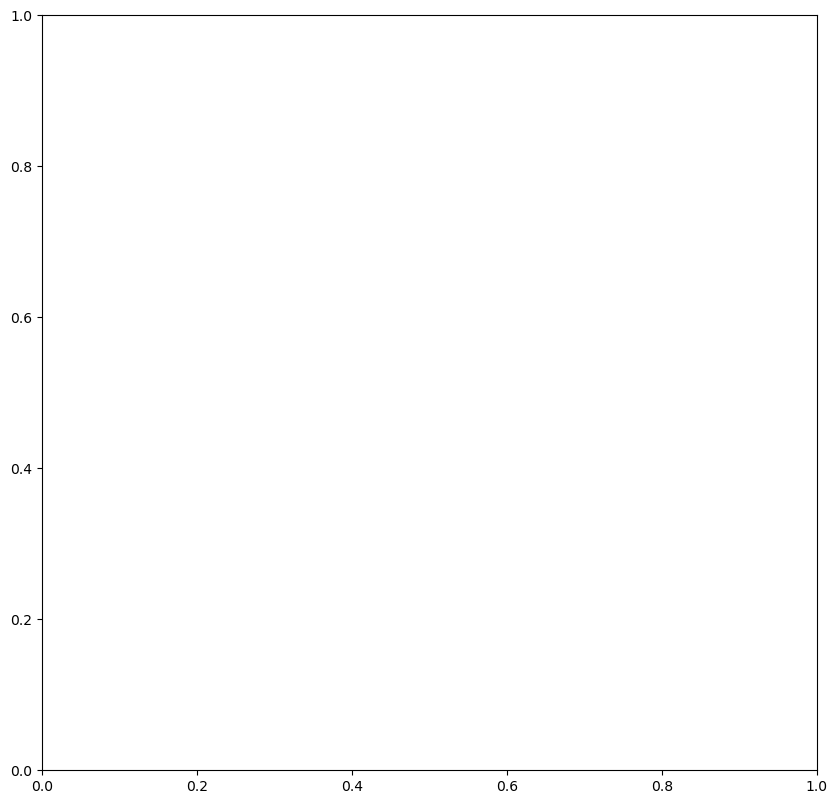

In [63]:
plt.rcParams["figure.figsize"] = (10, 10)
fig, ax = plt.subplots(1, dpi=100)
found = []
for item in dataSet['train']:
    if item['label'] == 1:
        found.append(item)

# Take first 5 images
trainSet, testSet = [os.path.join(topDir, path) for path in found[0]['paths'][:5]], [
    os.path.join(topDir, path) for path in found[1]['paths'][:5]
]

trainSet, testSet = [loadResizeImage(path) for path in trainSet], [loadResizeImage(path) for path in testSet]
composite = compose([compose(trainSet, 1), compose(testSet, 1)], 0)
plt.imshow(composite)
plt.show()


In [43]:
import json
# Save
with open('./utils/opencowsTracklets2020V2.json', 'w') as fp:
    json.dump(dataSet, fp)

In [1]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torchvision.models as models
import hiddenlayer as hl
from tqdm import tqdm
from torch import optim
import numpy
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from utils.OpenSetCows2021 import OpenSetCows2021TrackLet

testingDataset = OpenSetCows2021TrackLet(
    "/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17",
    "utils/opencowsTracklets2020V2.json",
    maxSequenceLength=5,
    transform=False,
    split="train",
    trackletChoiceProb = 0.9,
)

testingDataLoader = DataLoader(
    testingDataset, batch_size=10, num_workers=1, shuffle=True
)

for i in range(len(testingDataset)):
    print(i)
    next(iter(testingDataLoader))

0
139 140
109 110
126 124
117 122
122 121
46 47
114 111
95 96
104 108
14 17
55 54
138 137
124 127
3 1
141 139
56 55
1
142 141
27 26
22 20
53 52
74 76
26 27
141 142
99 101
9 11
154 152
47 46
107 106
93 92
64 63
147 148
48 49
2
158 156
96 95
17 14
153 149
122 120
2 1
60 59
34 35
161 160
145 148
72 74
58 57
99 103
127 126
40 41
6 10
137 138
153 152
134 136
118 121
3
21 22
82 81
121 117
81 82
9 6
108 106
14 17
111 110
132 130
76 73
62 61
154 152
14 16
142 141
101 102
45 43
151 149
125 127
36 35
85 83


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x116cb74c0>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/metricLearning/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/metricLearning/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/metricLearning/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/metricLearning/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/metricLearning/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.sel

4
14 12
149 154
2 3
98 97
125 128
155 156
114 113
114 110
6 7
90 91
145 146
148 145
54 55
0 2
20 22
151 152
59 60
14 18
5
106 105
62 61
42 44
54 55
146 145
45 43
18 17
109 112
86 83
56 54
146 148
110 113
14 16
142 141
105 106
133 129
52 53
149 151
6
128 124
15 19
36 35
88 87
32 33
73 75
118 120
95 94
114 111
74 76
33 32
40 41
86 84
2 0
66 67
30 31
10 6
127 125
81 82
7
15 16
71 74
33 32
66 67
2 1
41 40
144 143
112 114
89 90
92 93
16 18
14 13
154 153
128 127
44 43
22 20
8
114 109
24 25
92 88
45 42
47 46
94 95
56 54
130 129
77 74
3 0
9 6
98 97
16 17
87 91
17 19
140 139
119 118
56 55
9
67 66
156 158
123 127
95 98
151 153
46 47
147 143
11 6
146 144
112 113
18 13
124 126
6 11
69 68
57 58
45 44
64 63
58 57
10
38 37
33 32
78 80
68 69
11 7
37 38
4 5
16 15
30 31
10 6
146 145
161 159
122 119
6 10
125 128
103 100
120 115
21 20
16 18
11
42 45
45 43
130 131
137 138
20 21
12 16
99 101
73 77
59 60
120 121
143 145
4 5
84 83
58 57
33 32
100 103
78 79
10 11
12
43 42
73 74
6 7
135 136
134 135
41 40
62 61
